In [1]:
%%time
import fastai
from fastai.vision.all import *
import tensorflow as tf
from pathlib import Path
torch.cuda.empty_cache()

CPU times: user 2.73 s, sys: 1.26 s, total: 3.99 s
Wall time: 3.64 s


In [2]:
%%time
#writer = tf.io.TFRecordWriter(FLAGS.output_path)
from tfrecord.tfrecord import *

Instructions for updating:
non-resource variables are not supported in the long term
CPU times: user 7.12 ms, sys: 0 ns, total: 7.12 ms
Wall time: 5.95 ms


In [3]:
%%time
def unpack_sample(feats):
    return {
        'class' : unpack_int64_list(feats['class']),
        'image' : unpack_bytes_list(feats['image'])
    }

CPU times: user 8 µs, sys: 3 µs, total: 11 µs
Wall time: 16.7 µs


In [4]:
path = Path.cwd()/"flowers/tfrecords-jpeg-224x224"

In [5]:
%%time
train_fnames = get_files(path/'train', extensions = '.tfrec')
test_fnames = get_files(path/'val', extensions = '.tfrec')

CPU times: user 4.43 ms, sys: 159 µs, total: 4.59 ms
Wall time: 8.23 ms


In [6]:
%%time
data = []
for name in train_fnames + test_fnames :
    r = Reader(str(name), unpack_sample)
    for sample in r :
        data.append([sample['image'][0], sample['class'][0]])
    #break

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
CPU times: user 1.03 s, sys: 805 ms, total: 1.83 s
Wall time: 2.81 s


In [7]:
%%time

get_x = lambda x: PILImage.create(io.BytesIO(x[0]))

get_y = lambda x: x[1]

def get_items(noop):
    return data


flowers = DataBlock(blocks = (ImageBlock, CategoryBlock),
                    get_items = get_items,
                    get_x = get_x,
                    get_y = get_y,
                    item_tfms = Resize(440),
                    batch_tfms = [*aug_transforms(size = 224, min_scale = 0.75), Normalize.from_stats(*imagenet_stats)])

CPU times: user 4.06 s, sys: 2.17 s, total: 6.23 s
Wall time: 9.66 s


In [8]:
%%time
model = xresnet34()
dls = flowers.dataloaders("", bs = 64, device = "cuda")

learn = Learner(dls, model, loss_func = LabelSmoothingCrossEntropyFlat(), metrics = accuracy, cbs = MixUp())

CPU times: user 1.22 s, sys: 49.5 ms, total: 1.27 s
Wall time: 1.2 s


/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


CPU times: user 801 ms, sys: 86.4 ms, total: 887 ms
Wall time: 639 ms


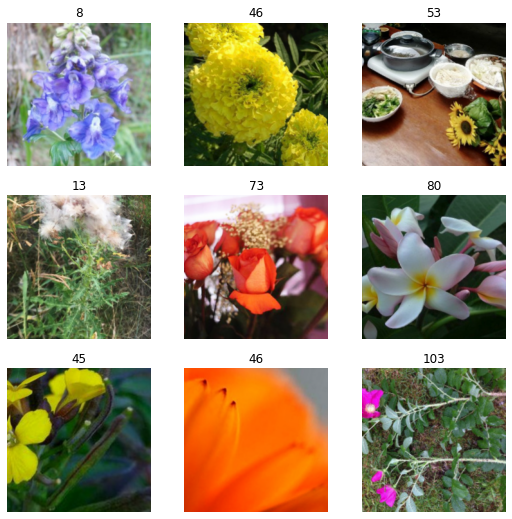

In [9]:
%%time
dls.show_batch()

In [10]:
%%time

learn.fit_one_cycle(15, slice(1e-5, 1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,4.184722,3.956597,0.212268,00:57
1,4.074445,3.753804,0.224415,00:56
2,3.909026,3.791903,0.204980,00:56
3,3.711373,3.298421,0.342241,00:56
4,3.433840,3.199946,0.375949,00:56
5,3.215348,2.824285,0.482842,00:56
6,3.027772,2.692304,0.521105,00:56
7,2.865738,2.374336,0.607045,00:56
8,2.746299,2.237614,0.643183,00:56
9,2.619950,1.987209,0.727604,00:56


/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


CPU times: user 8min 41s, sys: 4min 47s, total: 13min 29s
Wall time: 14min 4s


CPU times: user 93.1 ms, sys: 2.78 ms, total: 95.9 ms
Wall time: 90.3 ms


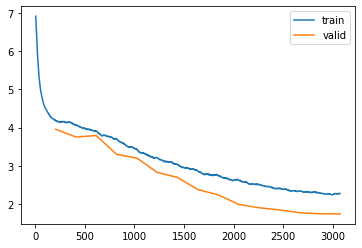

In [11]:
%%time
learn.recorder.plot_loss()

In [12]:
%%time

interp = ClassificationInterpretation.from_learner(learn)

CPU times: user 5.24 s, sys: 4.24 s, total: 9.49 s
Wall time: 8.51 s


CPU times: user 290 ms, sys: 25.2 ms, total: 315 ms
Wall time: 169 ms


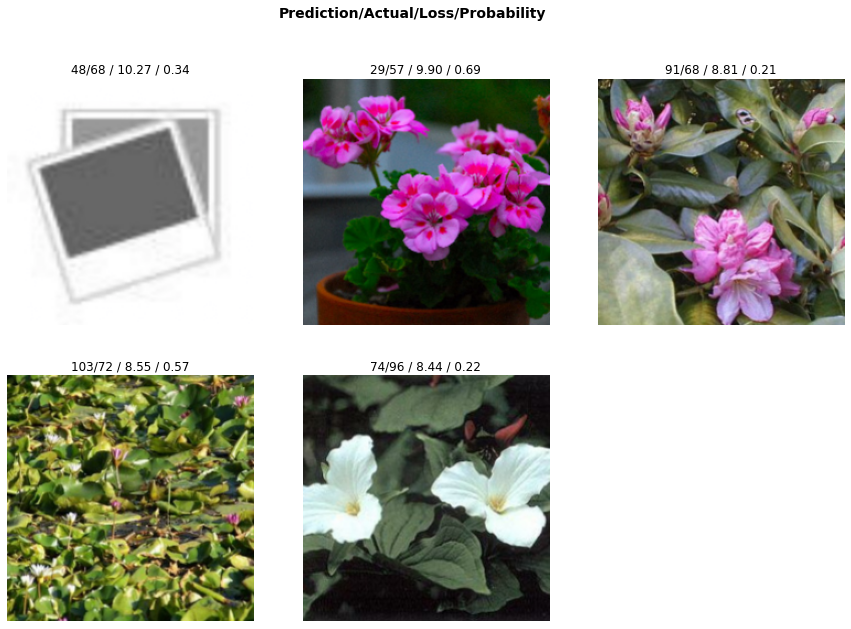

In [13]:
%%time

interp.plot_top_losses(5, nrows = 2, figsize = (15, 10))